In [1]:
# !pip install streamlit
# !pip install folium
# !pip install geocoder
# !pip install colour==0.1.1

In [2]:
# import libraries
import numpy as np
import pandas as pd
import folium
from folium.plugins import BeautifyIcon
import geocoder
import requests
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
import time
import pickle
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from colour import Color
from googletrans import Translator

### Step 1: [TomTom](https://developer.tomtom.com/) API Setting:

To be able to use TomTom api features, you have to register as a developer and get your own key, you can follow the steps in this article to issue your key [How to register a TomTom Api key](https://www.mapsmarker.com/kb/user-guide/how-tomtom-api/)

In [3]:
# My key is saved in file so need to retrive and set TomTom api key 
with open('help_files/tomtomapikey.txt') as f:
    api_key = f.readline()

### Step 2: Map Initialization

We here use [Folium](https://python-visualization.github.io/folium/) to visual our data on an interactive maps 

In [4]:
# A function to initialize any map using TomTom map.
def init_map(api_key, latitude=0, longitude=0, zoom=14, layer = "basic", style = "main"):
    """
    A function to initialize a clean TomTom map
    """
    
    maps_url = "http://{s}.api.tomtom.com/map/1/tile/"+layer+"/"+style+"/{z}/{x}/{y}.png?tileSize=512&key="
    TomTom_map = folium.Map(
        location = [latitude, longitude],  # on what coordinates [lat, lon] initialise the map
        zoom_start = zoom,
        tiles = str(maps_url + api_key),
        attr = 'TomTom')
    
    # add get latitude and longitude feature to our map
    folium.LatLngPopup().add_to(TomTom_map)
    
    return TomTom_map

In [5]:
init_map(api_key)

### Step 3: Center our Map on Your Location 

In our case that we run our script on PC and not all of them have GPS module to get your accurate location `latitude` and `longitude`. Therfore we instead could use GeoIP lookup to help with that. This involves getting the user’s public IP address and then using a database to convert that to a general location. 

This can be done in different ways using:
1. Libraries
2. RESTful APIs.
3. Selenium

P.S. I've tried many ways trying to get accurate GeoIP latitude and longitude.

#### Method 1: Use [geocoder](https://pypi.org/project/geocoder/) library

In [6]:
# save all my trials to get location
my_location_lst = []

In [7]:
# Request my location
my_location = geocoder.ip('me')

In [8]:
# show location result
my_location.geojson['features'][0]['properties']

{'address': 'Riyadh, Ar Riyāḑ, SA',
 'city': 'Riyadh',
 'country': 'SA',
 'ip': '51.36.225.90',
 'lat': 24.6877,
 'lng': 46.7219,
 'ok': True,
 'org': 'AS43766 MTC KSA',
 'raw': {'ip': '51.36.225.90',
  'city': 'Riyadh',
  'region': 'Ar Riyāḑ',
  'country': 'SA',
  'loc': '24.6877,46.7219',
  'org': 'AS43766 MTC KSA',
  'timezone': 'Asia/Riyadh',
  'readme': 'https://ipinfo.io/missingauth'},
 'state': 'Ar Riyāḑ',
 'status': 'OK'}

In [9]:
my_location_1 = [float(my_location.latlng[0]), float(my_location.latlng[1])]
print('latitude: ', my_location_1[0])
print('longitude: ', my_location_1[1])
my_location_lst.append(my_location_1)

latitude:  24.6877
longitude:  46.7219


#### Method 2: Use RESTful APIs

In [10]:
# step 1 : get my ip 
ip_request = requests.get('https://get.geojs.io/v1/ip.json')
my_ip = ip_request.json()['ip']
my_ip

'51.36.225.90'

In [11]:
# step 2_1 : get GEOIP latitude and longitude
geo_request = requests.get('https://get.geojs.io/v1/ip/geo/' +my_ip + '.json')
geo_data = geo_request.json()

In [12]:
my_location_2 = [float(geo_data['latitude']), float(geo_data['longitude'])]
print('latitude: ', my_location_2[0])
print('longitude: ', my_location_2[1])
my_location_lst.append(my_location_2)

latitude:  24.6537
longitude:  46.7152


> It's slightly different than what we got from library above

In [13]:
# step 2_2 : get GEOIP latitude and longitude
geo_request = requests.get('https://ipinfo.io/')
geo_data = geo_request.json()

In [14]:
my_location_3 = [float(i) for i in geo_data['loc'].split(',')]
print('latitude: ', my_location_3[0])
print('longitude: ', my_location_3[1])
my_location_lst.append(my_location_3)

latitude:  24.6877
longitude:  46.7219


> Same as `my_location_1`

In [615]:
# step 2_3 : get GEOIP latitude and longitude

# need api key for this request
with open('help_files/ipstackkey.txt') as f:
    api_key_loc = f.readline()
    
geo_request = requests.get(f"http://api.ipstack.com/{my_ip}?access_key={api_key_loc}")
geo_data = geo_request.json()

In [616]:
# show result 
geo_data

{'ip': '51.36.225.90',
 'type': 'ipv4',
 'continent_code': 'AS',
 'continent_name': 'Asia',
 'country_code': 'SA',
 'country_name': 'Saudi Arabia',
 'region_code': '01',
 'region_name': 'Ar Riyāḑ',
 'city': 'Riyadh',
 'zip': '11142',
 'latitude': 24.68773078918457,
 'longitude': 46.72185134887695,
 'location': {'geoname_id': 108410,
  'capital': 'Riyadh',
  'languages': [{'code': 'ar',
    'name': 'Arabic',
    'native': 'العربية',
    'rtl': 1}],
  'country_flag': 'http://assets.ipstack.com/flags/sa.svg',
  'country_flag_emoji': '🇸🇦',
  'country_flag_emoji_unicode': 'U+1F1F8 U+1F1E6',
  'calling_code': '966',
  'is_eu': False}}

In [617]:
my_location_4 = [float(geo_data['latitude']), float(geo_data['longitude'])]
print('latitude: ', my_location_4[0])
print('longitude: ', my_location_4[1])
my_location_lst.append(my_location_4)

latitude:  24.68773078918457
longitude:  46.72185134887695


In [623]:
# save resion code and city name for later use
my_region_code = geo_data['region_code']
my_region = geo_data['city']
my_region_code, my_region

('01', 'Riyadh')

> It seems more accurate right!

#### Method 3: Use Selenium

In [18]:
#create driver
options = Options()
options.add_argument("--use-fake-ui-for-media-stream")
timeout = 20
driver = webdriver.Chrome(executable_path = 'help_files/chromedriver/chromedriver', chrome_options=options)
# request page
driver.get("https://mycurrentlocation.net/")
wait = WebDriverWait(driver, timeout)
time.sleep(3)
longitude = driver.find_elements_by_xpath('//*[@id="longitude"]')
longitude = [x.text for x in longitude]
longitude = str(longitude[0])
latitude = driver.find_elements_by_xpath('//*[@id="latitude"]')
latitude = [x.text for x in latitude]
latitude = str(latitude[0])
driver.quit()

In [19]:
my_location_5 = [float(latitude), float(longitude)]
print('latitude: ', my_location_5[0])
print('longitude: ', my_location_5[1])
my_location_lst.append(my_location_5)

latitude:  24.71355
longitude:  46.6753


#### Since we already tried many ways to get my latitude and longitude, let's center our map using their average as follows:

In [20]:
my_location_lst

[[24.6877, 46.7219],
 [24.6537, 46.7152],
 [24.6877, 46.7219],
 [24.68773078918457, 46.72185134887695],
 [24.71355, 46.6753]]

In [21]:
my_latitude = sum([loc[0] for loc in my_location_lst])/len(my_location_lst)
my_longitude = sum([loc[1] for loc in my_location_lst])/len(my_location_lst)
print(my_latitude)
print(my_longitude)

24.686076157836915
46.711230269775385


In [22]:
tomtom_map = init_map(api_key, latitude=my_latitude, longitude=my_longitude)
tomtom_map

#### In our streamlit app, we will just use one method `ipstack` to get our location to save compution power 

### Step 4: Get Destination Point (Target Place):

In [23]:
# A function to add a point marker at any TomTom map.
def add_marker_map(tomtom_map, marker_latitude, marker_longitude, marker_title='point', marker_color='blue'):
    """
    A function to add a point marker at any TomTom map
    """
    folium.Marker(location=( marker_latitude, marker_longitude),
                  popup=marker_title, 
                  icon=folium.Icon(color=marker_color, icon='glyphicon-star')
             ).add_to(tomtom_map)
    
    return tomtom_map

- 1st Point: **Home**

In [24]:
# add marker for home point (detected current point from api)
tomtom_map = add_marker_map(tomtom_map, my_latitude, my_longitude, "your Location", 'blue')
tomtom_map

- 2nd Point: **Destination**

The current version of Folium maps does not have a feature to take the user mouse click as input, it would be great if it provides this!
<br>
<br>
Here, we are going to use the available feature from Folium `LatLngPopup()` that shows user latitude and longitude wherever he clicks on the map then do manual copy past for them in input boxes

![Alt Text](assets/input_lat_long.gif)

In [25]:
dest_latitude = float(input("Enter Destination Latitude :"))
# 24.6948

Enter Destination Latitude :24.6948


In [26]:
dest_longitude = float(input("Enter Destination Longitude :"))
#46.6803

Enter Destination Longitude :46.6803


In [27]:
def get_map_center_zoom(home_latitude, home_longitude, dest_latitude, dest_longitude):
    """Function to get center of folium map and zoom used"""
    # get center of our map based on home and destination points
    ave_lat = (home_latitude + dest_latitude) / 2
    ave_long = (home_longitude + dest_longitude) /2
    
    # calculate map zoom
    zoom = 14 #defuelt zoom
    latitude_diff = abs(home_latitude - dest_latitude)
    longitude_diff = abs(home_longitude - dest_longitude)
    
    if latitude_diff > longitude_diff:
        while latitude_diff > 0:
            zoom = zoom -1
            latitude_diff = latitude_diff - 0.1
    else:
        while longitude_diff > 0:
            zoom = zoom -1
            longitude_diff = longitude_diff - 0.1
    return ave_lat, ave_long, zoom

In [28]:
lat_, long_, zoom_ = get_map_center_zoom(my_latitude, my_longitude, dest_latitude, dest_longitude)

In [29]:
tomtom_map = init_map(api_key, latitude=lat_, longitude=long_, zoom=zoom_)
tomtom_map = add_marker_map(tomtom_map, my_latitude, my_longitude, "Your Location", 'blue')
tomtom_map = add_marker_map(tomtom_map, dest_latitude, dest_longitude, "destination Location", 'green')
tomtom_map

#### We can use [Fuzzy search](https://developer.tomtom.com/search?keywords=Address+%26+POI+search) and [autocomplete](https://developer.tomtom.com/search-api/search-api-documentation/autocomplete) Services to enter our destination as follows:

In [778]:
# autocomplete part
text = "King"
lang = "en-GB"
limit_ = 10

In [779]:
def autocomplete_search(text, lang, search_limit):
    """Function to retrieve result for given text"""

    # Gather all paramters in dict
    params_ = {'countrySet' : 'SA',
               'language' : lang,
               'limit' : search_limit,
               'key' : api_key
              }
    # create a request 
    url = (f'https://api.tomtom.com/search/2/autocomplete/{text}.json')
    r = requests.get(url, params=params_)
    
    # check response status to make sure it went through
    if r.status_code == 200:
        result = r.json()
    return result   

In [780]:
autocomplete_search(text, lang, limit_)

{'context': {'inputQuery': 'King'},
 'results': [{'segments': [{'type': 'brand',
     'value': 'BURGER KING',
     'matches': {'inputQuery': [{'offset': 0, 'length': 4}]}}]}]}

### Step 5: Find Shortest Route Between Two Points:

TomTom [Calculate Route](https://developer.tomtom.com/routing-api/routing-api-documentation-routing/calculate-route) service calculates a route between an origin and a destination based on historical traffic data.

- Information returned includes:
    - Distance (in meters)
    - Estimated travel time (in seconds)
    - Estimated arrival time
    
P.S. This service cannot predict sudden large-scale changes in road network utilization like the one many areas are experiencing due to the COVID-19 crisis

In [282]:
# Make the Request
r = requests.get(f"https://api.tomtom.com/routing/1/calculateRoute/{my_latitude},{my_longitude}:{dest_latitude},{dest_longitude}/xml?avoid=unpavedRoads&key={api_key}")

In [283]:
# check response status to make sure it went through
r.status_code

200

In [284]:
# Turn the XML data into a human readable format
soup = BeautifulSoup(r.content, "lxml")

# Print out the information
# print(soup.prettify())

In [285]:
def convert_sec_to_h_m(sec, hours=True ):
    """Function to convert sec to corresponding hours and minates or minates"""
    if hours:
        time_h = int(sec / (60*60))
        time_m = int((sec % (60*60)) /60)
    else:
        time_h = 0
        time_m = int(sec / 60)
    return time_h, time_m    

In [286]:
# get Estimated travel time
time_tot_sec = float(soup.find('summary').find('traveltimeinseconds').text)
time_h, time_m  = convert_sec_to_h_m(time_tot_sec)
print(f'Travel Time: {time_h} hours, {time_m} mins')

Travel Time: 0 hours, 8 mins


In [287]:
# get distance
print('Travel Distance:', float(soup.find('summary').find('lengthinmeters').text)/1000, 'Km')

Travel Distance: 6.193 Km


In [288]:
# get EAT
eta = soup.find('summary').find('arrivaltime').text.split('T')
eta_date = eta[0]
eta_time = eta[1].split('+')[0]
print(f'Estimated Arrival Date: {eta_date}')
print(f'Estimated Arrival Time: {eta_time}')

Estimated Arrival Date: 2020-06-23
Estimated Arrival Time: 22:39:09


In [289]:
# Find all the tags that contain a point in our route
points = soup.find_all('point')
points[:3]

[<point latitude="24.68610" longitude="46.71127"></point>,
 <point latitude="24.68597" longitude="46.71136"></point>,
 <point latitude="24.68578" longitude="46.71129"></point>]

In [290]:
# clean points list 
points = [tuple([float(point['latitude']), float(point['longitude'])]) for point in points ]
points[:3]

[(24.6861, 46.71127), (24.68597, 46.71136), (24.68578, 46.71129)]

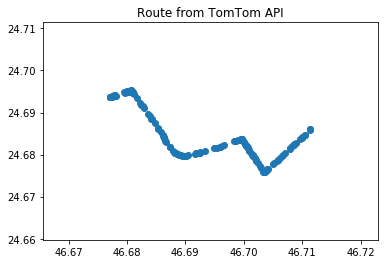

In [291]:
# draw your route using matplot

# Initialize our 2 arrays that will contain all the points
lat = [point[0] for point in points]
long = [point[1] for point in points]

# plot
plt.scatter(long,lat)
plt.title('Route from TomTom API')
plt.show()

In [292]:
# draw our route using Folium

def draw_route(points):
    """Function to draw a route between two points using folium"""
    
    # get center of our map based on obtained route
    ave_lat = sum(float(p[0]) for p in points)/len(points)
    ave_long = sum(float(p[1]) for p in points)/len(points)
    
    # initlize a map 
    TomTom_map = init_map(api_key, latitude=ave_lat, longitude=ave_long)

    #add a markers for home and destination points
    TomTom_map = add_marker_map(TomTom_map, points[0][0], points[0][1], marker_title='Your location', marker_color='blue')
    TomTom_map = add_marker_map(TomTom_map, points[-1][0], points[-1][1], marker_title='Your destination point', marker_color='red')


    # add lines 
    folium.PolyLine(points, color="green", weight=2.5, opacity=1).add_to(TomTom_map)

    return TomTom_map
    

In [293]:
tomtom_map = draw_route(points)
tomtom_map

### Step 6: Grab your Coffees in your way:

Let's try two different TomTom services to achive this task and find all possible options:

1. **TomTom [category Search](https://developer.tomtom.com/search-api/search-api-documentation-search/category-search) service**:
    - This service returns POI (Points of Interest) results around a location which are categorized as specified.
    - This service handles several categories, to check available categories, you can check the provided link above. For our script, we've saved them in a file so we can retrieve and try various categories.

In [515]:
with open('help_files/categories.txt') as f:
    poi_categories = f.read().replace('"', '').split(',')

In [516]:
# check first 10 categories
poi_categories[:10]

['(sub) urban',
 ' access gateway',
 ' administrative area',
 ' administrative division',
 ' adventure sports venue',
 ' adventure vehicle',
 ' advertising/marketing',
 ' afghan',
 ' african',
 ' agricultural school']

In [296]:
# let's search for cafes category (around one point)

In [709]:
# specify paramters for API (you could check out folloing paramters and more using link above)

# maximum number of responses (POI) that will be returned (1-100)
search_limit = 100 

# The results will be constrained to the defined area (radius) in meters.
search_radius = 500

# place category 
category = 'coffee'

In [710]:
def get_cafes_around_point(dest_latitude, dest_longitude, search_limit, search_radius, category):
    """Function to retrieve cafes around given point"""

    # Gather all paramters in dict
    params_ = {'countrySet' : 'SA',
               'lat' : dest_latitude,
               'lon' : dest_longitude,
               'limit' : search_limit,
               'radius' : search_radius,
               'key' : api_key
              }
    # create a request 
    url = (f'https://api.tomtom.com/search/2/categorySearch/{category}.json')
    r = requests.get(url, params=params_)
    
    # check response status to make sure it went through
    if r.status_code == 200:
        result = r.json()
    return result   

In [711]:
result = get_cafes_around_point(dest_latitude, dest_longitude, search_limit, search_radius, category)

In [712]:
# show how many POI returned
len(result['results'])

11

In [713]:
# show how every place in the result
result['results'][0]

{'type': 'POI',
 'id': 'g6JpZK82ODIwMDkwMDA1MTk1NTihY6NTQVWhdqdVbmlmaWVk',
 'score': 2.5745251178741455,
 'dist': 89.9022089251954,
 'info': 'search:ta:682009000519558-SA',
 'poi': {'name': 'Naomy for Organic Tea',
  'categorySet': [{'id': 9376005}],
  'categories': ['café/pub', 'tea house'],
  'classifications': [{'code': 'CAFE_PUB',
    'names': [{'nameLocale': 'en-US', 'name': 'café/pub'},
     {'nameLocale': 'en-US', 'name': 'tea house'}]}]},
 'address': {'streetName': 'Prince Muhammad Bin Abdulaziz Road',
  'municipalitySubdivision': 'Al Olaya',
  'municipality': 'Riyadh',
  'countrySubdivision': 'Riyadh Province',
  'postalCode': '12212',
  'countryCode': 'SA',
  'country': 'Saudi Arabia',
  'countryCodeISO3': 'SAU',
  'freeformAddress': 'Prince Muhammad Bin Abdulaziz Road, Riyadh Province, Riyadh',
  'localName': 'Riyadh'},
 'position': {'lat': 24.69497, 'lon': 46.68117},
 'viewport': {'topLeftPoint': {'lat': 24.69587, 'lon': 46.68018},
  'btmRightPoint': {'lat': 24.69407, 'lon'

In [714]:
# draw shortest route between home and dest
tomtom_map = draw_route(points)

# add a grey circle to represent the search radius
folium.Circle(
    [dest_latitude, dest_longitude],
    radius=search_radius,
    color='#004B7F', # Navy
    opacity=0.3,
    fill = False
).add_to(tomtom_map)

# Add POIs one by one to the map
for poi in result['results']:
    folium.Marker(location=tuple(poi['position'].values()),
                  popup=str(poi['poi']['name']), 
                  icon=folium.Icon(color='purple', icon='glyphicon-star')
             ).add_to(tomtom_map)
tomtom_map

- You can press on any marker to show cafe shop name 

#### We can get use of this service more Efficient by Retrieving cafes in given area by providing area center points `lon/lat`

In [669]:
# let's get area center points

In [670]:
def SearchCity(city, country):
    """ Function use Geocoding feature in Search API to get lat/lon of the center of a city or area"""
    
    url = f'https://api.tomtom.com/search/2/search/{city},{country}.json?limit=1&idxSet=Geo&key={api_key}'
    result = requests.get(url).json()
    
    GeoID = result['results'][0]['dataSources']['geometry']['id']
    position = result['results'][0]['position']
    
    return GeoID,position

In [671]:
# from your location we can identify the resion name 
my_region_code, my_region

('01', 'Riyadh')

In [672]:
# let's try 'KAl Hamra' area in riyadh city
GeoID, position = SearchCity('Al Hamra' ,my_region)
lat_area = position['lat']
lon_area = position['lon']
print("The center of the neighborhood is: (", lat_area, ", ", lon_area, ")")

The center of the neighborhood is: ( 24.77586 ,  46.75362 )


To get all Saudi regions to use them later in Streamlit app, we can use **[National Address API](https://api.address.gov.sa/lookupsapi-cities)**:

In [673]:
def getPolygon(GeoID,zoomLevel):
    """ Function to get polygon of a given GeoID"""
    
    url = f'https://api.tomtom.com/search/2/additionalData.json?geometries={GeoID}&geometriesZoom={zoomLevel}&key={api_key}'
    result = requests.get(url).json()
    
    GeoJson = result['additionalData'][0]['geometryData']
    
    return GeoJson

In [674]:
Polygon = getPolygon(GeoID,22)

In [675]:
with open('help_files/nationaladdapikey.txt') as f:
    nationaladd_key = f.read()

In [688]:
def get_saudi_regions(key):
    """Function to return all Saudi Arabia regions names in english and arabic"""
    
    regions = dict()
    
    # request En cities names
    citys_request_ar = requests.get(f'https://apina.address.gov.sa/NationalAddress/v3.1/lookup/regions?language=A&format=json&api_key={key}')
    
    time.sleep(5)
    
    # request Ar cities names
    citys_request_en = requests.get(f'https://apina.address.gov.sa/NationalAddress/v3.1/lookup/regions?language=E&format=json&api_key={key}')
    
    if citys_request_en.status_code == 200 and citys_request_ar.status_code == 200:
        
        cities_en = citys_request_en.json()['Regions']
        cities_ar = citys_request_ar.json()['Regions']
        for en_city, ar_city in zip(cities_en, cities_ar):
            if not regions.get(int(en_city['Id']),0):
                regions[int(en_city['Id'])]={}
            if not regions.get(int(ar_city['Id']),0):
                regions[int(ar_city['Id'])] = {}

            regions[int(en_city['Id'])][0] = en_city['Name']
            regions[int(ar_city['Id'])][1] = ar_city['Name']
    return regions

In [689]:
ksa_cities = get_saudi_regions(nationaladd_key)
ksa_cities

{6: {0: 'Asir', 1: ' عسير'},
 12: {1: ' الباحة', 0: 'Bahah'},
 13: {1: ' الجوف', 0: 'Jawf'},
 5: {0: 'Eastern Province', 1: 'الشرقية'},
 9: {1: ' الحدود الشمالية', 0: 'Northern Borders'},
 8: {0: 'Hail', 1: ' حائل'},
 1: {1: ' الرياض', 0: 'Riyadh'},
 4: {1: ' القصيم', 0: 'Qassim'},
 10: {0: 'Jizan', 1: ' جازان'},
 3: {1: ' المدينة المنورة', 0: 'Madinah'},
 7: {1: ' تبوك', 0: 'Tabuk'},
 2: {0: 'Makkah', 1: ' مكة المكرمة'},
 11: {0: 'Najran', 1: ' نجران'}}

In [693]:
# save it to load it again in the streamlit app
with open('help_files/sa_regions.pkl', 'wb') as f:
    pickle.dump(ksa_cities, f)

In [679]:
# draw area on map

#initialize new map
tomtom_map = init_map(api_key, lat_area, lon_area)


# add polygons to a map
folium.GeoJson(Polygon).add_to(tomtom_map)

tomtom_map

In [684]:
result = get_cafes_around_point(lat_area, lon_area, search_limit, search_radius, category)

In [685]:
#
len(result['results'])

4

In [686]:
# Add POIs one by one to the map
for poi in result['results']:
    folium.Marker(location=tuple(poi['position'].values()),
                  popup=str(poi['poi']['name']), 
                  icon=folium.Icon(color='green', icon='glyphicon-star')
                  #icon=icon
             ).add_to(tomtom_map)
tomtom_map


> This service just considers one point and try to get the nearest places within a radius. **What about the other places along the route from home point to destination point! Maybe there are better options!**

2. **TomTom [Along Route Search](https://developer.tomtom.com/search-api/search-api-documentation-search/along-route-search) service**:
    - This service allows you to perform a search for POIs along a specified route (from home point to destination point).

    - This search is constrained by specifying a detour time-limiting measure.
    
    - To specify the route, we should provide points along it (from Home point to Destination point) 
         - The minimum number of route points is 2.
         - A good scenario for route points is using a start point and an end point and some middle points, therefore in our request here we will try to use 6 points to describe our route:
            - Home point (start point)
            - 4 middle points
            - Destination point (end point)

> **i. Finding all cafes along the route (between home and destination point)**

In [305]:
# helper func:

In [306]:
def get_route_points(points, num_points):
    """Function returns distributed selected number of points along route (array of points)"""
    
    # calculate step between each 2 points
    step = len(points)// (num_points + 2) # num_points +1 for start point +1 for end points
    
    # return points
    return [{'lat':points[step * i][0], 'lon':points[step * i][1]} for i in range(1,num_points+1)]

In [307]:
def tomtom_category_sets():
    """Function to dataframe of categories supported by tomtom api"""
    
    res = requests.get(f'https://api.tomtom.com/search/2/poiCategories.json?key={api_key}')
    if res.status_code == 200:
        cat_res = json.loads(res.text)
        cat_df = pd.DataFrame(cat_res['poiCategories'])
        return cat_df

In [308]:
# specify paramters for API (you could check out folloing paramters and more using link above)

# route points points[0][0], points[0][1],
route_dict={"points": [{"lat": points[0][0], "lon": points[0][1]}] #start point
            + get_route_points(points, 4) # 4 middle points
            + [{"lat": points[-1][0],"lon": points[-1][1]}] # end point
           }
api_points = {"route":route_dict}

# maximum detour time limit (sec)
max_detour_time=200


# maximum number of responses that will be returned.
max_res_limit = 20


# return calculation of the distance between the start of the route and the starting point of the detour to a POI.
detour_offset = True

# categories to restrict the result to the Points Of Interest of specific categories. 
# The list of categories can be discovered using the POI Categories endpoint.
category_set_df = tomtom_category_sets()
category_set_df.head()

,id,name,childCategoryIds,synonyms
0,7320,Sports Center,"[7320002, 7320003, 7320005]","[Gym, Indoors Sports, Sports Centre]"
1,7374,Stadium,"[7374002, 7374009, 7374012, 7374003, 7374010, ...","[Arena, Gymnasium, Sports Ground, Sports Stadium]"
2,7315,Restaurant,"[7315081, 7315002, 7315082, 7315003, 7315083, ...","[Dining, Eatery, Eating House, Eating Place]"
3,9376,Café/Pub,"[9376002, 9376006, 9376004, 9376007, 9376003, ...","[Ale House, Public House, Tavern]"
4,9663,Health Care Service,"[9663005, 9663004, 9663003, 9663002]",[]


In [762]:
# save some categories for later use in streamlit app
category_set_lang_df = category_set_df[['id', 'name']].iloc[[121, 2, 206, 8, 215, 220, 587, 579, 577, 5, 39, 11, 260, 25,  147,   335],:].copy()

In [763]:
translator = Translator()
category_set_lang_df['name_ar'] = category_set_lang_df.name.map(lambda x: translator.translate(x, dest='ar').text)
category_set_lang_df

,id,name,name_ar
121,9376002,Café,قهوة
2,7315,Restaurant,مطعم
206,7315015,Fast Food,الوجبات السريعة
8,7332,Market,سوق
215,9361018,Bakery,مخبز
220,9361023,Grocery Store,بقالة
587,7328,Bank,مصرف
579,7397,ATM,ماكينة الصراف الآلي
577,7311,Gas Station,محطة غاز
5,7321,Hospital,مستشفى


In [764]:
# save it to load it again in the streamlit app
with open('help_files/categories.pkl', 'wb') as f:
    pickle.dump(category_set_lang_df, f)

In [378]:
def get_cafes_along_route(detour_time, res_limit, cafe_brand=None):
    """Function to retrieve cafes spread over given route"""
    # Gather all paramters in dict
    params_ = {'maxDetourTime' : detour_time,
               'detourOffset' : json.dumps(True),
               'limit' : res_limit,
               'categorySet' : category_set_df[category_set_df['name']=='Café/Pub']['id'],
               'key': api_key
              } 
    # add place brand if it's provided
    if cafe_brand:
        params_['brandSet'] = cafe_brand
            
    # create a request
    headers = {'Content-type': 'application/json'}
    response = requests.post(f'https://api.tomtom.com/search/2/searchAlongRoute/{category}.json',
                             json=api_points,
                             headers=headers,
                             params=params_)
    
    # check response status to make sure it went through
    if response.status_code == 200:
        res = json.loads(response.text) 
    return res   

In [344]:
res = get_cafes_along_route(max_detour_time, max_res_limit)

In [345]:
# check response
res.keys()

dict_keys(['summary', 'results'])

In [346]:
# show how many POI returned
res['summary']['totalResults']

20

In [347]:
# show how every place in the result
res['results'][4]

{'type': 'POI',
 'id': 'g6JpZK82ODIwMDkwMDA1MzIxNDShY6NTQVWhdqdVbmlmaWVk',
 'score': 2.997896194458008,
 'dist': 116.90260388771955,
 'info': 'search:ta:682009000532144-SA',
 'poi': {'name': 'Al Awaleen Coffee',
  'categorySet': [{'id': 9376006}],
  'categories': ['café/pub', 'coffee shop'],
  'classifications': [{'code': 'CAFE_PUB',
    'names': [{'nameLocale': 'en-US', 'name': 'café/pub'},
     {'nameLocale': 'en-US', 'name': 'coffee shop'}]}]},
 'address': {'streetName': 'Makkah Al Mukarrama Road',
  'municipalitySubdivision': 'Al Olaya',
  'municipality': 'Riyadh',
  'countrySubdivision': 'Riyadh Province',
  'postalCode': '12221',
  'countryCode': 'SA',
  'country': 'Saudi Arabia',
  'countryCodeISO3': 'SAU',
  'freeformAddress': 'Makkah Al Mukarrama Road, Riyadh Province, Riyadh',
  'localName': 'Riyadh'},
 'position': {'lat': 24.6827, 'lon': 46.69676},
 'viewport': {'topLeftPoint': {'lat': 24.6836, 'lon': 46.69577},
  'btmRightPoint': {'lat': 24.6818, 'lon': 46.69775}},
 'entryP

In [348]:
# show returned places names and address
for ind, i in enumerate(res['results']):
    print("\033[1m"+f"{ind+1}. {i['poi']['name']}"+"\033[0m")
    print(i['poi']['name'], ',', i.get('address').get('streetName',''),',', i['address']['municipalitySubdivision'])
    print('\n')

1. Naomy for Organic Tea
Naomy for Organic Tea , Prince Muhammad Bin Abdulaziz Road , Al Olaya


2. Dunkin'
Dunkin' , King Fahd Road , Al Olaya


3. Al Awaleen Coffee - Jalsat Shaabiyah
Al Awaleen Coffee - Jalsat Shaabiyah , Makkah Al Mukarrama Road , Al Olaya


4. Java Time
Java Time , Makkah Al Mukarrama Road , Al Olaya


5. Al Awaleen Coffee
Al Awaleen Coffee , Makkah Al Mukarrama Road , Al Olaya


6. Najdeyat Haleeb and Heal
Najdeyat Haleeb and Heal , Makkah Al Mukarrama Road , Al Olaya


7. Roma Cafe
Roma Cafe ,  , Al Olaya


8. Dan Kon
Dan Kon , Madaen Saleh Street , Al Olaya


9. Dallatna Lounge
Dallatna Lounge , Prince Muhammad Bin Abdulaziz Road , Al Olaya


10. Coffee Net
Coffee Net , Wady Al Tairy Street , Al Olaya


11. Paris Coffee
Paris Coffee , Wadi Al Amaria Street , Al Olaya


12. Black House
Black House , 50 Street , Al Olaya


13. London Pastries And Coffee
London Pastries And Coffee ,  , Al Olaya


14. Madar Al Hayah Center For Internet
Madar Al Hayah Center For Int

### Visualize the map that shows the following:
    - Home point 
    - Destination point
    - The shortest route between both points
    - Returned places:
        - Each place marker has a number indicate the oreder of the place based on its detour time.
            - ex: the place with the shortest derout time will have number 1 then the second shortest place will have number 2 and so on. 
        - Each place has a different coloer and size repersents its derout time
            - ex: the place with the shortest derout time will have darkest color and bigger size then the second shortest place be little bit lighter and smaller and so on. 
        - Each place has 2 popup windows:
            1. Popup window that showup when pressing on the marker to give you some location's information (name, full address) .
            2. Popup window that showup when  hovering over the marker to give you some location's information (name, derout time) .

In [351]:
def draw_along_search_map(res):
    """Function to draw returned result of along_search service on map"""
    
    # draw home, destination, shortest route between them
    tomtom_map = draw_route(points)

    # create heat colors scale for markers to show Priority of the place
    # we chose here blue gradients
    colors = list(Color("#000080").range_to(Color("#d5e5ff"),max_res_limit))

    # for each returened place
    for ind, poi in enumerate(res['results']):

        # calculate detour time for this place in minutes 
        detour_h, detour_min = convert_sec_to_h_m(poi['detourTime'], False)

        # create marker on the place has own size and color
        icon_ = BeautifyIcon(icon_shape='marker',
                             number=ind,
                             spin=True,
                             text_color='gray',
                             icon_size=(40-ind, 40-ind),
                             border_color =str(colors[ind]),
                             background_color=str(colors[ind]),
                             inner_icon_style="font-size:12px;padding-top:-5px;"
                            )

        # add a marker for each lat, lon
        folium.Marker(location=tuple(poi['position'].values()),
                      popup=folium.Popup(f"<b>{poi['poi']['name']}</b> <br>{poi.get('address').get('streetName','')}, {poi['address']['municipalitySubdivision']}", max_width=100) , 
                      icon=icon_,
                      tooltip=f"<b>{poi['poi']['name']}</b> <br> ({detour_min} mins)"
                 ).add_to(tomtom_map)
    return tomtom_map

In [352]:
# map
draw_along_search_map(res)

> **ii. Finding all cafes of a specific brand name along the route (between home and destination point)**

In [379]:
# we want to restrict the result to Points Of Interest of specific brands ex:"Dunkin'"
res_Dunkin = get_cafes_along_route(max_detour_time, max_res_limit, "Dunkin'")

In [380]:
# show how many POI returned
res_Dunkin['summary']['totalResults']

5

In [382]:
# show returned places names and address
for ind, i in enumerate(res_Dunkin['results']):
    print("\033[1m"+f"{ind+1}. {i['poi']['name']}"+"\033[0m")
    print(i['poi']['name'], ',', i.get('address').get('streetName',''),',', i['address']['municipalitySubdivision'])
    print('\n')

1. Dunkin'
Dunkin' , King Fahd Road , Al Olaya


2. Dunkin'
Dunkin' , Prince Muhammad Bin Abdulaziz Road , Al Olaya


3. Dunkin'
Dunkin' , Al Moatasem Street , Al Olaya


4. Dunkin'
Dunkin' , Haba Allah Al Samry Alley , Al Olaya


5. Dunkin'
Dunkin' , Makkah Al Mukarrama Road , Al Olaya




In [383]:
# map
draw_along_search_map(res_Dunkin)